In [0]:
#Imports
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim 
import torch.nn.functional as F
from torchvision import datasets, transforms
import random
from random import shuffle
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from tabulate import tabulate
import copy
import os, time
import itertools
import pickle
from torch.autograd import Variable

In [0]:
# Hyper-Parameters

hparams={
    'batch_size':200,
    'test_batch_size':200,
    'validation_batch_size':200,
    'num_epochs':5,
    'learning_rate':1e-3,
    'learning_rate_small':1e-4,
    'log_interval':150,
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

hparams_architecture={
    'kernel_size_l1':5,
    'kernel_size_l2':5,
    'padding':2,
    'num_filters_l1':35,
    'num_filters_l2':50,
    'stride':2,
}


random_seed= 25
np.random.seed(random_seed)
torch.manual_seed(random_seed)
shuffle_dataset = True

# **Exercise 1. Convolutional Autoencoder:** 
STEPS:

1. Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.

In [3]:
#Normalize the data to have mean=0 and variance=1
train_set=datasets.MNIST('data',train=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))]),download=True)
test_set=datasets.MNIST('data',train=False,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))]),download=True)

#### Validation split ######
split_p=0.05
split=int(np.floor(split_p*len(train_set))) 

indices = list(range(len(train_set)))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PyTorch Subsets:
train_subset= torch.utils.data.Subset(train_set, train_indices)
valid_subset = torch.utils.data.Subset(train_set, val_indices)

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=hparams['batch_size'])
validation_loader = torch.utils.data.DataLoader(valid_subset, batch_size=hparams['batch_size'])
test_loader = torch.utils.data.DataLoader(test_set ,batch_size=hparams['test_batch_size'])

0it [00:00, ?it/s]

9920512it [00:06, 1637063.40it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 142105.85it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2343967.13it/s]                            
  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 53812.79it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).

In [0]:
#Conv Block includes a Conv2D layer, a ReLU, and a Pooling layer, to simplify implementation of larger blocks
class ConvBlock(nn.Module):

  def __init__(self, num_inp_channels, num_out_fmaps, 
               kernel_size, pool_size=2):
    super().__init__()

    self.conv=nn.Conv2d(num_inp_channels,
                        num_out_fmaps,
                        kernel_size, 
                        padding=hparams_architecture['padding']
                        )
    
    self.relu=nn.ReLU()

    self.maxpool=nn.MaxPool2d(pool_size)
  
  def forward(self, x):
    return self.maxpool(self.relu(self.conv(x)))

###############################################################################

class Encoder(nn.Module):

  def __init__(self, bottleneck):
    super().__init__()


    
    self.conv1 = ConvBlock(1, 
                           hparams_architecture['num_filters_l1'], 
                           hparams_architecture['kernel_size_l1']
                           )
    
    self.conv2 = ConvBlock(hparams_architecture['num_filters_l1'], 
                           hparams_architecture['num_filters_l2'], 
                           hparams_architecture['kernel_size_l2']
                           )
    
    self.flat=nn.Flatten()

    self.lin=nn.Linear(in_features=((int(28/(hparams_architecture['stride']**2))**2)*hparams_architecture['num_filters_l2']),
                       out_features=bottleneck)

  def forward(self,x):

    x=self.conv1(x)
    x=self.conv2(x)
    x=self.flat(x)
    y=self.lin(x)
    
    return y

#################################################################################

class Decoder(nn.Module):
    
  def __init__(self, bottleneck):
    super().__init__()
    
    self.lin=nn.Linear(in_features=bottleneck,
                      out_features=(int(28/(hparams_architecture['stride']**2))**2)*hparams_architecture['num_filters_l2'])  

    self.deconv_l1=nn.ConvTranspose2d(in_channels=hparams_architecture['num_filters_l2'],
                        out_channels=hparams_architecture['num_filters_l1'],
                        kernel_size=hparams_architecture['kernel_size_l2'],
                        stride=hparams_architecture['stride'],
                        padding=hparams_architecture['padding'],
                        output_padding=1)

    self.deconv_l2=nn.ConvTranspose2d(in_channels=hparams_architecture['num_filters_l1'],
                        out_channels=1,
                        kernel_size=hparams_architecture['kernel_size_l1'],
                        stride=hparams_architecture['stride'],
                        padding=hparams_architecture['padding'],
                        output_padding=1)
    
    self.relu=nn.ReLU()

  def forward(self,x):
    x=self.lin(x)
    x=x.view(-1, hparams_architecture['num_filters_l2'],int(28/4),int(28/4))
    y=self.relu(self.deconv_l2(self.relu(self.deconv_l1(x))))
    return y

###############################################################################

class Autoencoder(nn.Module):
  def __init__(self,bottleneck):
    super().__init__()

    self.encoder = Encoder(bottleneck)
    self.decoder = Decoder(bottleneck)

  def forward(self,x):
    x=self.encoder(x)
    y=self.decoder(x)
    return y

3. Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.

In [0]:
#Epoch function definitions

def train_epoch(train_loader, network, optimizer, criterion, hparams):

  network.train()
  device = hparams['device']
  train_losses = []
  for batch_idx, (data,target) in enumerate(train_loader):
      data = data.to(device)      
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, data, reduction='sum')
      loss.backward()
      train_losses.append(loss.item()/hparams['batch_size'])
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()/hparams['batch_size']))
  return train_losses

def val_epoch(validation_loader, network, hparams, plot_boolean):

  network.eval()
  device = hparams['device']
  validation_loss = 0
  with torch.no_grad():
      for batch_idx, (data,target) in enumerate(validation_loader):
          data = data.to(device)
          output = network(data)
          validation_loss += criterion(output, data, reduction='sum').item() 
  validation_loss /= len(validation_loader.dataset)
  if plot_boolean:
    print('\n Validation set: Average loss: {:.4f} \n'.format(validation_loss))
  return validation_loss

Begin training network with bottleneck size 2

Train Epoch: 1 [0/57000 (0%)]	Loss: 787.445938
Train Epoch: 1 [30000/57000 (53%)]	Loss: 698.104844

 Validation set: Average loss: 693.4324 

Train Epoch: 2 [0/57000 (0%)]	Loss: 697.792187
Train Epoch: 2 [30000/57000 (53%)]	Loss: 644.375352

 Validation set: Average loss: 589.5427 

Train Epoch: 3 [0/57000 (0%)]	Loss: 594.911914
Train Epoch: 3 [30000/57000 (53%)]	Loss: 555.340508

 Validation set: Average loss: 521.5123 

Train Epoch: 4 [0/57000 (0%)]	Loss: 529.143906
Train Epoch: 4 [30000/57000 (53%)]	Loss: 502.037969

 Validation set: Average loss: 492.9503 

Train Epoch: 5 [0/57000 (0%)]	Loss: 501.388203
Train Epoch: 5 [30000/57000 (53%)]	Loss: 487.593008

 Validation set: Average loss: 476.0515 

Begin training network with bottleneck size 10

Train Epoch: 1 [0/57000 (0%)]	Loss: 808.015156
Train Epoch: 1 [30000/57000 (53%)]	Loss: 523.487188

 Validation set: Average loss: 429.7578 

Train Epoch: 2 [0/57000 (0%)]	Loss: 434.110547
Train 

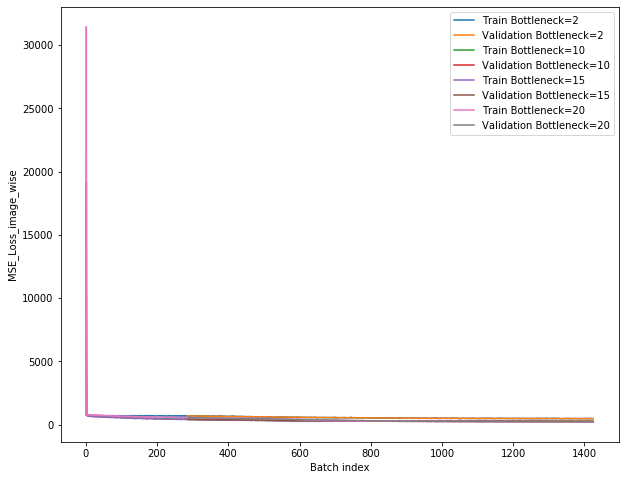

In [6]:
#Run the training (long time)

bottleneck_array=[2,10,15,20]

network_array=[]
for i in range(0,len(bottleneck_array)):
  network_array.append(Autoencoder(bottleneck_array[i]))

plt.figure(figsize=(10, 8))

for pos in range(0,len(bottleneck_array)):
    tr_losses = []
    val_losses = []

    bottleneck=bottleneck_array[pos]
    network=network_array[pos]
    print('Begin training network with bottleneck size {}'.format(bottleneck) + '\n')

    network.to(hparams['device'])
    optimizer = optim.RMSprop(network.parameters(), lr=hparams['learning_rate'])
    criterion = F.mse_loss

    for epoch in range(1, hparams['num_epochs'] + 1):
      tr_losses.append(train_epoch(train_loader, network, optimizer, criterion, hparams))
      val_loss = val_epoch(validation_loader, network, hparams,True)
      val_losses.append(val_loss)

    tr_loss_flat = [item     for sublist in tr_losses     for item in sublist]
    plt.xlabel('Batch index')
    plt.ylabel('MSE_Loss_image_wise')
    plt.plot(range(0, len(train_loader)*hparams['num_epochs']), tr_loss_flat, label='Train Bottleneck='+str(bottleneck))
    plt.plot(range(len(train_loader), (hparams['num_epochs']+1)*len(train_loader), len(train_loader)), val_losses, label='Validation Bottleneck='+str(bottleneck))
    plt.legend()

4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.

In [0]:
def model_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn 
    return pp

In [8]:
#VALIDATION MSE_error

validation_error=[]
for i in range(0,len(network_array)):
  validation_error.append(val_epoch(validation_loader, network_array[i], hparams,plot_boolean=False))

#TEST MSE_error

test_error=[]
for i in range(0,len(network_array)):
  test_error.append(val_epoch(test_loader, network_array[i], hparams,plot_boolean=False))

#NUMBER OF PARAMETERS
number_param=[]
for i in range(0,len(network_array)):
  number_param.append(model_params(network_array[i]))


header=['Bootleneck Size','Validation error','Test error', 'Number of parameters']  
data=np.array([bottleneck_array,validation_error,test_error,number_param])

print(tabulate(data.transpose(),header))

  Bootleneck Size    Validation error    Test error    Number of parameters
-----------------  ------------------  ------------  ----------------------
                2             476.051       475.496                  101623
               10             267.182       264.765                  140831
               15             227.389       225.127                  165336
               20             231.906       229.055                  189841


5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.

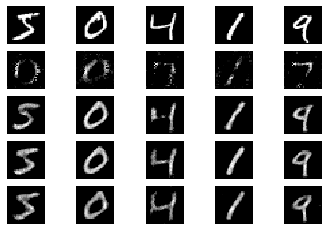

In [9]:
N=5
images=train_set.data[0:N]
image=images.view(N,1,28,28)

images_out_set=[]

dtype_t = torch.cuda.FloatTensor
for i in range(0,len(network_array)):
  images_out_set.append(network_array[i](image.cpu().type(dtype_t)).view(-1,28,28).cpu().int())

f,matrix=plt.subplots(len(bottleneck_array)+1, N)

for i in range(0,len(bottleneck_array)+1):
  for j in range(0,N):
    if i==0:
      matrix[i,j].imshow(images[j],cmap='gray')
    else:
      matrix[i,j].imshow(images_out_set[i-1][j],cmap='gray')
    matrix[i,j].axis('off')

6. Generate 5 new images by injecting random values as input to the decoder. Show them.

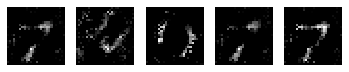

In [10]:
N=5
pos=0
device=hparams['device']
random_input=torch.randn(N,bottleneck_array[pos])*255
random_input=random_input.to(device)

images_art=network_array[pos].decoder(random_input)
images_art=images_art.view(-1,28,28)
images_art=images_art.cpu().int()

f,array=plt.subplots(1, N)

for j in range(0,N):
  array[j].imshow(images_art[j],cmap='gray')
  array[j].axis('off')

# **Exercise 2. Transfer Learning**

Steps:
1. Select a subset of 100 images and their associated labels from the MNIST training data.

2. Select one of the previously trained autoencoders.

3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.

4. Pre-training: use the weights of the autoencoders as initial values for the network weights and train a classification model on the subset of 100 samples.

5. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.

6. From scratch: train a model on the 100 samples without reusing the decoder weights at all.

7. Show the accuracy of the four models on the MNIST test set in a table.

In [11]:
N=100
list_images = list(range(0, N))

trainset_class = torch.utils.data.Subset(train_set, list_images)

trainloader_class = torch.utils.data.DataLoader(trainset_class, batch_size=10, shuffle=True)

print("Num of samples: ", len(trainloader_class.dataset))

Num of samples:  100


2. Select one of the previously trained autoencoders.

3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.

In [0]:
num_classes = 10
class ClassifierMNIST(nn.Module):

    def __init__(self, bottleneck, encoder):
      super().__init__()
      self.encoder = encoder
      self.lin=nn.Linear(bottleneck, num_classes)
      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim=1)


    def forward(self,x):
      x = self.encoder(x)
      x = self.lin(x)
      y = self.softmax(x)
      return y

In [0]:
#Training function definitions

def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) 
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_class_epoch(train_loader, network, optimizer, criterion, hparams):

  network.train()
  device = hparams['device']
  train_losses = []

  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      train_losses.append(loss.item())
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return train_losses

def val_class_epoch(validation_loader, network, criterion, hparams, type_set):

    # if type_set = True --> validation phase
    # if type_set = False --> testing phase
    network.eval()
    
    device = hparams['device']
    val_loss = 0
    acc = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(validation_loader):
            data, target = data.to(device), target.to(device)
            output = network(data)
            val_loss += criterion(output, target).item()        
            acc += correct_predictions(output, target)

    # Average accuracy across all correct predictions batches
    val_loss /= len(validation_loader)
    val_acc = 100. * acc / len(validation_loader.dataset)

    if type_set:
      print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          val_loss, acc, len(validation_loader.dataset), val_acc,
          ))
    else:
      print('Testing set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          val_loss, acc, len(validation_loader.dataset), val_acc,
          ))
    return val_loss, val_acc

4. Pre-training: use the weights of the autoencoders as initial values for the network weights and train a classification model on the subset of 100 samples.

5. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.

6. From scratch: train a model on the 100 samples without reusing the decoder weights at all.

In [14]:
pos=1
encoder_net1 = copy.deepcopy(network_array[pos].encoder)
encoder_net2 = copy.deepcopy(network_array[pos].encoder)
bottleneck=bottleneck_array[pos]
criterion_class=nn.NLLLoss()

# Pre-trained metrics
tr_losses_pt = []
val_losses_pt = []
val_accs_pt = []
test_losses_pt = []
test_accs_pt = []

#Pre-training
print("Pre-training:")
print("-------------")
network1=ClassifierMNIST(bottleneck, encoder_net1)
network1.to(hparams['device'])
optimizer1 = optim.RMSprop([
                            {'params':network1.lin.parameters()},
                            {'params':network1.encoder.parameters(), 'lr':0}],
                           lr=hparams['learning_rate'])


for epoch in range(1, hparams['num_epochs'] + 1):
  # Training phase
  tr_losses_pt.append(train_class_epoch(trainloader_class, network1, optimizer1, criterion_class, hparams))
  # Validation phase
  val_loss_class, acc_val = val_class_epoch(validation_loader, network1, criterion_class, hparams, type_set=True)
  val_losses_pt.append(val_loss_class)
  val_accs_pt.append(acc_val)
  # Testing phase
  test_loss_class, acc_test = val_class_epoch(test_loader, network1, criterion_class, hparams, type_set=False)
  test_losses_pt.append(test_loss_class)
  test_accs_pt.append(acc_test)
  
tr_loss_pt_flat = [item     for sublist in tr_losses_pt     for item in sublist]

Pre-training:
-------------
Train Epoch: 1 [0/100 (0%)]	Loss: -0.044182
Validation set: Average loss: -0.1199, Accuracy: 349/3000 (12%)

Testing set: Average loss: -0.1173, Accuracy: 1188/10000 (12%)

Train Epoch: 2 [0/100 (0%)]	Loss: -0.092612
Validation set: Average loss: -0.1537, Accuracy: 546/3000 (18%)

Testing set: Average loss: -0.1503, Accuracy: 1729/10000 (17%)

Train Epoch: 3 [0/100 (0%)]	Loss: -0.166678
Validation set: Average loss: -0.1840, Accuracy: 727/3000 (24%)

Testing set: Average loss: -0.1801, Accuracy: 2382/10000 (24%)

Train Epoch: 4 [0/100 (0%)]	Loss: -0.185915
Validation set: Average loss: -0.2114, Accuracy: 913/3000 (30%)

Testing set: Average loss: -0.2070, Accuracy: 2972/10000 (30%)

Train Epoch: 5 [0/100 (0%)]	Loss: -0.249772
Validation set: Average loss: -0.2367, Accuracy: 1004/3000 (33%)

Testing set: Average loss: -0.2322, Accuracy: 3284/10000 (33%)



In [15]:
#Fine-tuning metrics
tr_losses_ft = []
val_losses_ft = []
val_accs_ft = []
test_losses_ft = []
test_accs_ft = []

#Fine-tuning
print("Fine-tuning:")
print("------------")
network2=ClassifierMNIST(bottleneck, encoder_net2)
network2.to(hparams['device'])
optimizer2 = optim.RMSprop([
                            {'params':network2.lin.parameters()},
                            {'params':network2.encoder.parameters(), 'lr':hparams['learning_rate_small']}],
                           lr=hparams['learning_rate'])

for epoch in range(1, hparams['num_epochs'] + 1):
  # Training phase
  tr_losses_ft.append(train_class_epoch(trainloader_class, network2, optimizer2, criterion_class, hparams))
  # Validation phase
  val_loss_class, acc_val = val_class_epoch(validation_loader, network2, criterion_class, hparams, type_set=True)
  val_losses_ft.append(val_loss_class)
  val_accs_ft.append(acc_val)
  # Testing phase
  test_loss_class, acc_test = val_class_epoch(test_loader, network2, criterion_class, hparams, type_set=False)
  test_losses_ft.append(test_loss_class)
  test_accs_ft.append(acc_test)

tr_loss_ft_flat = [item     for sublist in tr_losses_ft     for item in sublist]

Fine-tuning:
------------
Train Epoch: 1 [0/100 (0%)]	Loss: -0.070032
Validation set: Average loss: -0.1052, Accuracy: 336/3000 (11%)

Testing set: Average loss: -0.1051, Accuracy: 1213/10000 (12%)

Train Epoch: 2 [0/100 (0%)]	Loss: -0.113173
Validation set: Average loss: -0.1649, Accuracy: 625/3000 (21%)

Testing set: Average loss: -0.1615, Accuracy: 2071/10000 (21%)

Train Epoch: 3 [0/100 (0%)]	Loss: -0.203653
Validation set: Average loss: -0.2215, Accuracy: 802/3000 (27%)

Testing set: Average loss: -0.2170, Accuracy: 2659/10000 (27%)

Train Epoch: 4 [0/100 (0%)]	Loss: -0.300799
Validation set: Average loss: -0.2651, Accuracy: 941/3000 (31%)

Testing set: Average loss: -0.2616, Accuracy: 3112/10000 (31%)

Train Epoch: 5 [0/100 (0%)]	Loss: -0.392939
Validation set: Average loss: -0.2970, Accuracy: 1033/3000 (34%)

Testing set: Average loss: -0.2935, Accuracy: 3399/10000 (34%)



In [16]:
#From Scratch metrics
tr_losses_fs = []
val_losses_fs = []
val_accs_fs = []
test_losses_fs = []
test_accs_fs = []

#From Scratch
print("From-scratch:")
print("-------------")
network3=ClassifierMNIST(bottleneck, Encoder(bottleneck))
network3.to(hparams['device'])
optimizer3 = optim.RMSprop(network3.parameters(), lr=hparams['learning_rate'])


for epoch in range(1, hparams['num_epochs'] + 1):
  # Training phase
  tr_losses_fs.append(train_class_epoch(trainloader_class, network3, optimizer3, criterion_class, hparams))
  # Validation phase
  val_loss_class, acc_val = val_class_epoch(validation_loader, network3, criterion_class, hparams, type_set=True)
  val_losses_fs.append(val_loss_class)
  val_accs_fs.append(acc_val)
  # Testing phase
  test_loss_class, acc_test = val_class_epoch(test_loader, network3, criterion_class, hparams, type_set=False)
  test_losses_fs.append(test_loss_class)
  test_accs_fs.append(acc_test)

tr_loss_fs_flat = [item     for sublist in tr_losses_fs     for item in sublist]

From-scratch:
-------------
Train Epoch: 1 [0/100 (0%)]	Loss: -0.108350
Validation set: Average loss: -0.1123, Accuracy: 337/3000 (11%)

Testing set: Average loss: -0.1135, Accuracy: 1135/10000 (11%)

Train Epoch: 2 [0/100 (0%)]	Loss: -0.000000
Validation set: Average loss: -0.1123, Accuracy: 337/3000 (11%)

Testing set: Average loss: -0.1135, Accuracy: 1135/10000 (11%)

Train Epoch: 3 [0/100 (0%)]	Loss: -0.399991
Validation set: Average loss: -0.1123, Accuracy: 337/3000 (11%)

Testing set: Average loss: -0.1135, Accuracy: 1135/10000 (11%)

Train Epoch: 4 [0/100 (0%)]	Loss: -0.300000
Validation set: Average loss: -0.1123, Accuracy: 337/3000 (11%)

Testing set: Average loss: -0.1135, Accuracy: 1135/10000 (11%)

Train Epoch: 5 [0/100 (0%)]	Loss: -0.100000
Validation set: Average loss: -0.1123, Accuracy: 337/3000 (11%)

Testing set: Average loss: -0.1135, Accuracy: 1135/10000 (11%)



Plot the loss curves (Train and Validation) for the 3 models above

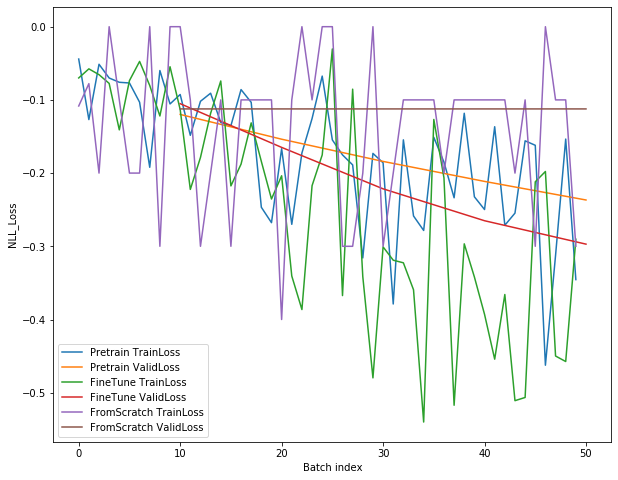

In [17]:
plt.figure(figsize=(10, 8))
plt.xlabel('Batch index')
plt.ylabel('NLL_Loss')
plt.plot(range(0, len(trainloader_class)*hparams['num_epochs']), tr_loss_pt_flat, label='Pretrain TrainLoss')
plt.plot(range(len(trainloader_class), (hparams['num_epochs']+1)*len(trainloader_class), len(trainloader_class)), val_losses_pt, label='Pretrain ValidLoss')
plt.plot(range(0, len(trainloader_class)*hparams['num_epochs']), tr_loss_ft_flat, label='FineTune TrainLoss')
plt.plot(range(len(trainloader_class), (hparams['num_epochs']+1)*len(trainloader_class), len(trainloader_class)), val_losses_ft, label='FineTune ValidLoss')
plt.plot(range(0, len(trainloader_class)*hparams['num_epochs']), tr_loss_fs_flat, label='FromScratch TrainLoss')
plt.plot(range(len(trainloader_class), (hparams['num_epochs']+1)*len(trainloader_class), len(trainloader_class)), val_losses_fs, label='FromScratch ValidLoss')
plt.legend()

7. Show the accuracy of the three models on the MNIST test set in a table.

In [18]:
models = np.array(["Pre-trained", "Fine-tuned", "From-scratch"])
test_accuracies = np.array([test_accs_pt[-1], 
                            test_accs_ft[-1], 
                            test_accs_fs[-1]])

header=['Model', 'Accuracy']
data=np.array([models,test_accuracies])

print(tabulate(data.transpose(),header))

Model           Accuracy
------------  ----------
Pre-trained        32.84
Fine-tuned         33.99
From-scratch       11.35


**Exercise 3. Variational Autoencoder**

Steps:

1. Implement an autoencoder like that from Exercise 1, but turning the deterministic bottleneck into a stochastic bottleneck, with an isotropic Gaussian as distribution for the latent variables.

2. Train the model optimizing the Evidence Lower Bound (ELBO).

3. Generate samples with the decoder and show them.

In [0]:
class Encoder_double(nn.Module):

  def __init__(self, bottleneck):
    super().__init__()

    self.conv1 = ConvBlock(1, 
                           hparams_architecture['num_filters_l1'], 
                           hparams_architecture['kernel_size_l1']
                           )
    
    self.conv2 = ConvBlock(hparams_architecture['num_filters_l1'], 
                           hparams_architecture['num_filters_l2'], 
                           hparams_architecture['kernel_size_l2']
                           )
    
    self.flat=nn.Flatten()

    self.lin=nn.Linear(in_features=((int(28/(hparams_architecture['stride']**2))**2)*hparams_architecture['num_filters_l2']),
                       out_features=2*bottleneck)

  def forward(self,x):

    x=self.conv1(x)
    x=self.conv2(x)
    x=self.flat(x)
    y=self.lin(x)
    y=y.view(-1,2,bottleneck)    
    return y

class VAE(nn.Module):

  def __init__(self,bottleneck):
    super().__init__()
    self.encoder = Encoder_double(bottleneck)
    self.decoder = Decoder(bottleneck)

  def forward(self,x):
    values=self.encoder(x)
    means=values[:,0,:]
    log_sigmas=values[:,1,:] #To be sure that sigma is positive.
    z=torch.exp(log_sigmas)*torch.randn(means.size(dim=1),dtype=means.dtype,device=means.device)+means
    y=self.decoder(z)
    return y,log_sigmas,means

In [0]:
#Loss function.
class loss_class:

  def __init__(self):
    super().__init__()

  def loss_function(data,data_out,means,log_sigmas):
    #Two components of the loss: reconstruction+KL divergence.
    #KL divergence can be computed using the means and variances (because we are assuming
    #that all the distributions are normal). (see appendix B of Auto-Encoding Variational Bayer; Kingma)
    DKL=-1/2*torch.sum(1+2*log_sigmas-means**2-torch.exp(2*log_sigmas)) 
    reconstruction_loss=F.mse_loss(data,data_out,reduction='sum')

    total_loss=reconstruction_loss+DKL
    return total_loss

In [0]:
def train_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = []

  for batch_idx, (data,target) in enumerate(train_loader):
      data = data.to(device)      
      optimizer.zero_grad()
      output, log_sigmas, means = network(data)
      loss = criterion(data,output,means,log_sigmas)
      loss.backward()
      avg_loss.append(loss.item()/hparams['batch_size'])
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()/hparams['batch_size']))
  return avg_loss

def val_epoch(validation_loader, network, hparams, plot_boolean):
    network.eval()
    device = hparams['device']
    validation_loss = 0
    #avg_weight = 0.1
    with torch.no_grad():
        for batch_idx, (data,target) in enumerate(validation_loader):
            data = data.to(device)
            output, log_sigmas, means = network(data)
            validation_loss += criterion(data,output,means,log_sigmas).item()/hparams['batch_size'] # sum up batch loss
            #if validation_loss:
            #  validation_loss = avg_weight * current_loss.item() + (1 - avg_weight) * validation_loss
            #else:
            #  validation_loss = current_loss.item()

    # Average loss across all correct predictions batches now
    validation_loss /= len(validation_loader)
    if plot_boolean:
      print('\n Validation set: Average loss: {:.4f} \n'.format(validation_loss))
    return validation_loss

Train Epoch: 1 [0/57000 (0%)]	Loss: 805.493281
Train Epoch: 1 [30000/57000 (53%)]	Loss: 404.294883

 Validation set: Average loss: 339.4229 

Train Epoch: 2 [0/57000 (0%)]	Loss: 343.244648
Train Epoch: 2 [30000/57000 (53%)]	Loss: 323.106562

 Validation set: Average loss: 306.9042 

Train Epoch: 3 [0/57000 (0%)]	Loss: 315.997109
Train Epoch: 3 [30000/57000 (53%)]	Loss: 300.330898

 Validation set: Average loss: 296.8990 

Train Epoch: 4 [0/57000 (0%)]	Loss: 304.024746
Train Epoch: 4 [30000/57000 (53%)]	Loss: 297.582617

 Validation set: Average loss: 289.0789 

Train Epoch: 5 [0/57000 (0%)]	Loss: 298.520742
Train Epoch: 5 [30000/57000 (53%)]	Loss: 287.102539

 Validation set: Average loss: 284.8333 



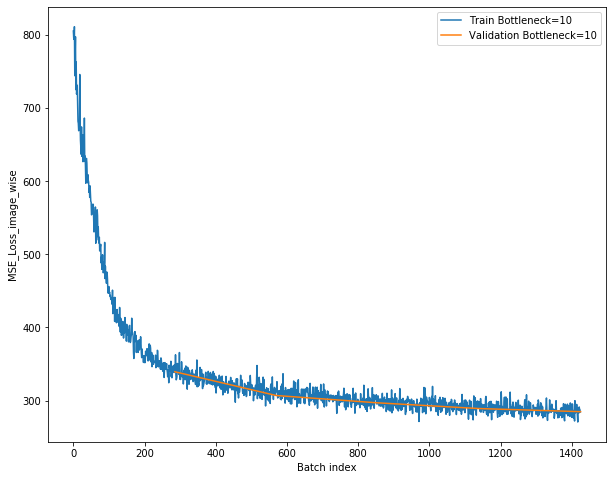

In [26]:
tr_losses = []
val_losses = []

bottleneck=10
network=VAE(bottleneck)
network.to(hparams['device'])
optimizer = optim.Adam(network.parameters(), lr=hparams['learning_rate'])
criterion = loss_class.loss_function

for epoch in range(1, hparams['num_epochs'] + 1):
    # Trainig phase
    tr_losses.append(train_epoch(train_loader, network, optimizer, criterion, hparams))
    # Validation phase
    val_loss = val_epoch(validation_loader, network, hparams,True)
    val_losses.append(val_loss)

tr_loss_flat = [item     for sublist in tr_losses     for item in sublist]
plt.figure(figsize=(10, 8))

plt.xlabel('Batch index')
plt.ylabel('MSE_Loss_image_wise')
plt.plot(range(0, len(train_loader)*hparams['num_epochs']), tr_loss_flat, label='Train Bottleneck='+str(bottleneck))
plt.plot(range(len(train_loader), (hparams['num_epochs']+1)*len(train_loader), len(train_loader)), val_losses, label='Validation Bottleneck='+str(bottleneck))
plt.legend()

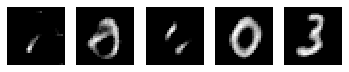

In [30]:
#3. Generate samples with the decoder and show them.

N=5 #Number of samples
device=hparams['device']
z=torch.randn(N,bottleneck).to(device)

images_art=network.decoder(z)
images_art=images_art.view(-1,28,28)*10
images_art=images_art.cpu().int()

f,array=plt.subplots(1, N)

for j in range(0,N):
  array[j].imshow(images_art[j],cmap='gray')
  array[j].axis('off')

**Exercise 4. Conditional GAN**

Steps:

1. Implement a generator and discriminator based on deconvolutions and convolutions respectively.

2. Train the GAN on MNIST.

3. Generate samples with the generator and show them.

In [0]:
# 1. Implement a generator and discriminator based on deconvolutions and convolutions respectively

